# Ensembles

We will be running the following ensembles in this notebook: 
0 to 3 is from Gro More
4to 6 is FOE
7 to 9 is Aquaseca

Stipulations for ensembles:
- no seasonality
- run monthly
- Aquaseca's notebook was our base model

Parameter Values
- 1. K1, K2, and K3 = [5, 25, 100] # baseline Kx=Ky=Kz value in all zones (m/day)
- 2. Kz ratio_lowK = [1e-6, 1e-2, 1] # ratio of Kz in low-K layer to baseline K (-)
- 3. Sy = [0.05, 0.1, 0.3] # specific yield (-)
- 4. R_mountains = [1e-5, 3e-5, 5e-5] # recharge rate in mountains (m/day)
- 5. ET_valley = [1e-6, 1e-5, 1e-4] # ET rate in valley (m/day)
- 6. ETratio_riparian = [1, 2, 3] # ratio of ET in riparian area to ET rate in valley (m/day)
- 7. Kratio_streambed = [1e-2,1e-1, 1] # ratio of K in streambed to baseline K (-)


# 1. Packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os
import csv

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

run = 'n'
if run == 'y':
    file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    for ext in file_extensions:
        os.remove(modelname + ext)

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/flopy


 ## Name of run and Parameter Inputs

In [2]:
ensembles = [[1,3,3,3,1,1,3],#gro more
[3,1,3,3,1,1,3], #gro more
[3,1,1,1,3,3,1],#gro more
[1,1,1,1,3,3,1],# gro more
[2,1,2,1,3,3,1],#foe
[2,1,2,1,3,1,1],#foe
[2,1,2,2,1,1,1],#foe
[2,2,1,3,2,2,3],#aq
[2,2,1,1,2,2,1],#aq
[1,1,1,1,1,1,1]]#aq

ensemble_num = ensembles[1]#change ensemble here
#print(ensemble_num)

barley = 1 #if 1 then crops are switched
wellmove = 0 # if 1 then well is moved


name = "ensemble_"
for i in range(len(ensemble_num)):
    string = str(ensemble_num[i])
    name = name + string 
    
if(barley == 1 ):
    name = name + 'b'
elif(wellmove == 1):
    name = name + 'w'
    
print(name)

ensemble_3133113b


# 2. Discretization and other inputs

In [3]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
#print(type(ztop))
#print(ztop.shape)
#print(ztop[0,:])
zbot = 0.     #bottom elevation


## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
uncnf = 1       #0=confined, >0 = unconfined


#supply well
pumping = 0 #m3/day 
well_xy= [38000, 29000] #xy location of well 
well_row = np.floor((nrow)-(well_xy[1]/dy)) #convert the y location to a row
well_col=np.floor(well_xy[0]/dx) #convert the x location to a column
well_row = 29
well_col = 37
well_loc = (0,well_row, well_col)
well = [2,well_row, well_col, pumping] #Well loc shoudl be layer, row, column
#print("well1 location(layer, col, row)", well_row, well_col)


#MW1
pumping2 = 0 #m3/day 
well2_xy= [25000, 25000] #xy location of well 
well2_row = np.floor((nrow)-(well2_xy[1]/dy)) #convert the y location to a row
well2_col=np.floor(well2_xy[0]/dx)-1 #convert the x location to a column
well2_loc = (0,well2_row, well2_col)
well2 = [0,well2_row, well2_col, pumping2] #Well loc shoudl be layer, row, column
#print("well2 location(layer, col, row)", well2_row, well2_col)

#MW2
pumping3 = 0 #m3/day 
well3_xy= [12500, 12500] #xy location of well 
well3_row = np.floor((nrow)-(well3_xy[1]/dy)) #convert the y location to a row
well3_col=np.floor(well3_xy[0]/dx) #convert the x location to a column
well3_loc = (0,well3_row, well3_col)
well3 = [0,well3_row, well3_col, pumping3] 
#print("well3 location(layer, col, row)", well3_row, well3_col)



#irrigation well
if (barley == 1):
    pumping4 = -2250 #the water that makes the beer
else:
    pumping4 = -4500 #m3/day
    
if (wellmove == 1): 
    well4_row = 19
else:  
    well4_row = 38 
well4_col = 12 
well4_loc = (0,well4_row, well4_col)
well4 = [0,well4_row, well4_col, pumping4] 
print("well4 location(layer, col, row)", well4_row, well4_col)

#wel_spd = {0: [well, well2, well3, well4]}
#print(len(wel_spd))


## Timing
# nper = 1 #number of stress periods 
# steady = [True] #list noting the stress period type

well4 location(layer, col, row) 38 12


## 2.1 Parameters that change

### Specific yield

In [4]:
if ensemble_num[2] == 1:
    Sy = 0.05  #lowest   #assign specific yield
elif ensemble_num[2] == 2:
    Sy = 0.1
else:
    Sy = 0.3   #highest
print(Sy)

0.3


### Recharge

In [5]:
#R_mountains = [1e-5, 3e-5, 5e-5]
if ensemble_num[3] == 1:
    rech=1e-5  #m/d #lowest   #assign specific yield
elif ensemble_num[3] == 2:
    rech=3e-5
else:
    rech=5e-5  #m/d

#print(rech)
rechxy=[(0,0),(0,36000)]  #recharge zone

rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

agrech_rows_forced = (28.0, 30.0) #rech zone forced for leftmost 15 cols
agrech_cols_forced = (18.0, 20.0)

if (barley == 1):
    agrech = 0.000072 #barley recharge
else:
    agrech = 0.00015  #pistachios (1/8th area already included)

# rech_zone_forced = np.zeros((1, nrow,ncol))
# rech_zone_forced[0, int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
# rech_zone_forced[0, int(agrech_rows_forced[0]):int(agrech_rows_forced[1]),int(agrech_cols_forced[0]):int(agrech_cols_forced[1])]=agrech

# rech_rows=(np.floor(nrow-rechxy[1][1]/dy),np.floor(nrow-rechxy[0][1]/dy))
# rech_cols=(np.floor(rechxy[0][0]/dx),np.floor(rechxy[1][0]/dx))
# #rech_zone=np.zeros(1,nrow,ncol)
# #rech_zone[0,int(rech_rows[0]):int(rech_rows[1]),int(rech_cols[0]):int(rech_cols[1])]=rech
# print("recharge location(col, row)", rech_cols,rech_rows)

sp_peryr = 1   #number of seasons (with and wihtout ET. April-Sept and Oct-Mar)
sp_len = 360  #sp lengths
sim_years = 300
nper = int(sp_peryr*sim_years)+1

rech_zone_forced = np.zeros((1, nrow,ncol))
rech_zone_forced[0, int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
rech_zone_with_ag = np.zeros((1, nrow,ncol))
rech_zone_with_ag[0, int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
rech_zone_with_ag[0, int(agrech_rows_forced[0]):int(agrech_rows_forced[1]),int(agrech_cols_forced[0]):int(agrech_cols_forced[1])]=agrech


rech_dict = {}

for i in range(nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
    if i <= 199:
        rech_dict[i] = rech_zone_forced
        #print(i)
    elif i > 199:  
        #print(i)
        rech_dict[i] = rech_zone_with_ag



### K values

In [6]:
## K for layers 1 and 3 
if ensemble_num[0] == 1:
    K_horiz = 5 #m/d
    K_vert = 5 #m/d
elif ensemble_num[0] == 2:
    K_horiz = 25 #m/d
    K_vert = 25 #m/d
else:
    K_horiz = 100 #m/d
    K_vert = 100 #m/d
    
    
#Kzratio_lowK = [1e-6, 1e-2, 1] # ratio of Kz in low-K layer to baseline K (-)
if ensemble_num[1] == 1:
    K_horiz2 = K_horiz*1e-6 #m/d
    K_vert2 = K_vert*1e-6 #m/d
elif ensemble_num[1] == 2:
    K_horiz2 = K_horiz*1e-2 #m/d
    K_vert2 = K_vert*1e-2 #m/d
else:
    K_horiz2 = K_horiz*1 #m/d
    K_vert2 = K_vert*1 #m/d
    

## K for layer 2
# Kvert1 = 0.000001 #m/d  #K for the middle layer 
# Kvert2 = 0.01 #m/d
# Kvert3 = 1 #m/d

## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value
#Kz[1,:,:] = K_vert2
#print(K_horiz)
#print(Kz)

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 
print(K_horiz,K_vert, K_horiz2, K_vert2)

100 100 9.999999999999999e-05 9.999999999999999e-05


### Stream K

In [7]:
riv_row= 24
riv_sp = [] #create list to store all river cells for stress period 1


#Kratio_streambed = [1e-2,1e-1, 1] # ratio of K in streambed to baseline K (-)
if ensemble_num[6] == 1:
    k_rivbott = K_vert*0.01
elif ensemble_num[6] == 2:
    k_rivbott = K_vert*0.1
else:
    k_rivbott = K_vert*1


# k_rivbott1 = 0.01 #river bottom hydraulic conductivity in m/d
# k_rivbott3 = 1 #river bottom hydraulic conductivity in m/d
# # Kratio_streambed = [1e-2,1e-1, 1]

sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[riv_row,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
#print(riv_spd)
#create dictionary of stress period data
riv_spd = {0: riv_sp}
#print(riv_spd)

## 2.2 Stressperiods

In [8]:

nper = 301
#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
#print(steady)
steady[0] = True    # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp_len],sim_years)
perlen=np.append(100,perlen) #add a period of length 10 at the start for the steady state simulation
#print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 

nstp=perlen/30 #30 for monthly
#nstp[0]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)
#print("Number of Steps", nstp)


## Boundary conditions
h_right = 70

### Pumping and burnin

In [9]:
wel_spd = {}    
    
burn = 100 #0 because of the head file read in
decade = 1
#decade2 = 10 #to calculate pumping after 100 year pumping
pump = 47
pumpingag4 = pumping4
#total pumping = 
for strper in range(0, nper):    
    if strper < burn:
        pumping = 0
        wel_spd[strper] = [[2,well_row, well_col, pumping], [0, well4_row, well4_col, 0]]
    elif strper < (burn + 100):
        if strper < (burn+decade*10):
            pumping = round(pump * (decade**1.5)) *-1
            wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, well4_row, well4_col, 0]]
        else:
            decade = decade + 1   
            pumping = round(pump * (decade**1.5)) *-1
            wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, well4_row, well4_col, 0]]
    else:
        if strper < (burn+decade*10):
            pumping = round(pump * (decade**1.5)) *-1
            wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumpingag4]]
        else:
            decade = decade + 1   
            pumping = round(pump * (decade**1.5)) *-1
            wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumpingag4]]
    
#print(wel_spd)
#print(wel_spd)

### ET

In [10]:
## ET

# ET_valley = [1e-6, 1e-5, 1e-4] # ET rate in valley (m/day)
# ETratio_riparian = [1, 2, 3] # ratio of ET in riparian area to ET rate in valley (m/day)

#ET_valley = [1e-6, 1e-5, 1e-4] # ET rate in valley (m/day)
if ensemble_num[4] == 1:
    ET = 1e-6 #m/day
elif ensemble_num[4] == 2:
    ET = 1e-5 #m/day
else:
    ET = 1e-4 #m/day

# ETratio_riparian = [1, 2, 3] # ratio of ET in riparian area to ET rate in valley (m/day)
if ensemble_num[5] == 1:
    rip_ET = ET #m/day
elif ensemble_num[5] == 2:
    rip_ET = ET*2 #m/day
else:
    rip_ET = ET*3 #m/day
    

ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
#rip_ET= 5e-5  #riparian zone


rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m


ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 

rip_rows_forced = (21.0, 28.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)

rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 
#print("Riparian location(col, row)", rip_cols,rip_rows)       



ET_dict = {} #set up an ET dictionary, where each key is a stress period num 0-50
#ET_zone2 = ET_zone * 0 

for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
    ET_dict[p] = ET_zone


## 2.3 Ibounds

In [11]:
#read in burn-in head values
print(os.getcwd())
# H_init = np.ones((nlay, nrow, ncol), dtype=np.float32) 
# H_init[0,:,:] = np.loadtxt('postdev_toplayer_h_init.csv', delimiter=",")
# H_init[1,:,:] = np.loadtxt('postdev_midlayer_h_init.csv', delimiter=",")
# H_init[2,:,:] = np.loadtxt('postdev_botlayer_h_init.csv', delimiter=",")
# print(H_init[2,:,1])

H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value

#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

/Users/rachelspinti/Documents/HWRS_582/Aguaseca_Project/Advocacy


# 3. Run Modflow

In [12]:
#create model object
#modelname = "Ensemble_Test"
modelname = name
moddir="/Applications/MODFLOW/mf2005"
#moddir = "/Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mf2005"
#moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)


#Discretization - dis

dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp=nstp)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
#ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_dict, exdp=extinction_depth, ipakcb=53) 

#Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_dict, ipakcb=53)     #create rch object

#River - riv
riv = flopy.modflow.ModflowRiv(model=m, stress_period_data = riv_spd, ipakcb=53)

#Well - wel
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

# #Storage?
# sto = flopy.mf6.modflow.mfgwfsto.ModflowGwfsto(model=m, loading_package=False, save_flows=True, storagecoefficient=None, iconvert=0, ss=Ss, sy=Sy, transient=True)

#Output control - OC 

oc_spd = {}
for kper in range(0, nper):
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
# #print(np.shape(oc_spd))
#spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']}

oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

# oc_spd = {}
# for kper in range(0,nper-1): #nper is 201, this is the key for each entry in oc_spd dict
#     oc_spd[(kper, 1)] = ['save head','save drawdown','save budget','print head','print budget']
#     oc_spd[(kper, 90)] = ['save head','save drawdown','save budget','print head','print budget']
#     oc_spd[(kper, 179)] = ['save head','save drawdown','save budget','print head','print budget']
# oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=10000, iter1=1000, relax = 0.95, damp = 0.01)


#write the inputs
m.write_input()   

#check stuff
#m.evt.check()
# m.oc.check()
# m.oc.check()
# m.lpf.check()
# #m.pcg.check()
# m.riv.check()
# m.rch.check()
# m.dis.check()



#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /Applications/MODFLOW/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ensemble_3133113b.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/05/04 21:03:15

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:  

 Solving:  Stress period:    10    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     2    Ground-Wa

 Solving:  Stress period:    19    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     4    Ground-Wa

 Solving:  Stress period:    29    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     4    Ground-Wa

 Solving:  Stress period:    39    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     2    Ground-Wa

 Solving:  Stress period:    49    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:     7    Ground-Wa

 Solving:  Stress period:    59    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    10    Ground-Wa

 Solving:  Stress period:    70    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     1    Ground-Wa

 Solving:  Stress period:    80    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:     1    Ground-Wa

 Solving:  Stress period:    90    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     9    Ground-Wa

 Solving:  Stress period:   101    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     2    Ground-Wa

 Solving:  Stress period:   111    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     2    Ground-Wa

 Solving:  Stress period:   119    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    12    Ground-Wa

 Solving:  Stress period:   128    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    10    Ground-Wa

 Solving:  Stress period:   137    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     8    Ground-Wa

 Solving:  Stress period:   146    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     6    Ground-Wa

 Solving:  Stress period:   155    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:     4    Ground-Wa

 Solving:  Stress period:   164    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:     2    Ground-Wa

 Solving:  Stress period:   172    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    12    Ground-Wa

 Solving:  Stress period:   181    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    10    Ground-Wa

 Solving:  Stress period:   190    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:     8    Ground-Wa

 Solving:  Stress period:   199    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:     6    Ground-Wa

 Solving:  Stress period:   208    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:     4    Ground-Wa

 Solving:  Stress period:   217    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:     2    Ground-Wa

 Solving:  Stress period:   225    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    12    Ground-Wa

 Solving:  Stress period:   234    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    10    Ground-Wa

 Solving:  Stress period:   243    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     8    Ground-Wa

 Solving:  Stress period:   252    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:     6    Ground-Wa

 Solving:  Stress period:   261    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:     4    Ground-Wa

 Solving:  Stress period:   270    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:     2    Ground-Wa

 Solving:  Stress period:   278    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:    12    Ground-Wa

 Solving:  Stress period:   287    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:    10    Ground-Wa

 Solving:  Stress period:   296    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:     8    Ground-Wa

# 4. Plotting

### Domain grid

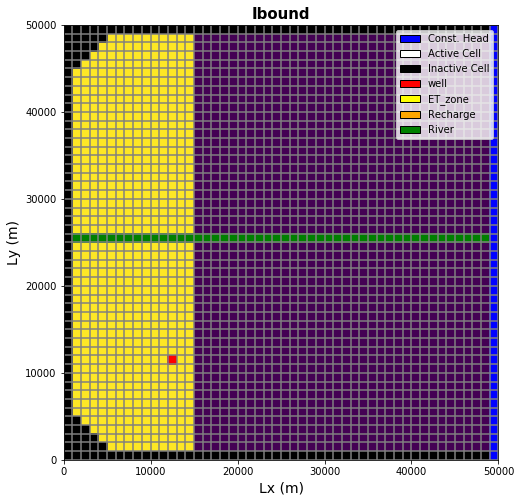

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
#zones = ET_zone + rech_zone_forced
quadmesh = modelmap.plot_array(rech_zone_forced)
#quadmesh = modelmap.plot_array(rech_zone_forced)

riv_plot = modelmap.plot_bc(ftype='RIV')
quadmesh = modelmap.plot_ibound(ibound[0])
wel = modelmap.plot_bc(ftype='WEL')
#quadmesh = modelmap.plot_array(rech_zone_forced) #, color='purple')
#riv_plot = modelmap.plot_bc(ftype='RIV')
#chd_plot = modelmap.plot_bc(ftype='CHD')
#quadmesh = modelmap.plot_bc('WEL')
quadmesh = modelmap.plot_ibound()



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                    mp.patches.Patch(color='red',label='well',ec='black'), 
                   mp.patches.Patch(color='yellow',label='ET_zone',ec='black'),
                    mp.patches.Patch(color='orange',label='Recharge',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='black')
                   ])

plt.show(modelmap)
#plt.savefig('Domaingrid.png')

### Read in binary files

In [14]:
#hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
#times = hds.get_times() # returns a list of timesteps
#times = []
# for t in range(len(perlen)):
#     if t == 0:
#         times.append(perlen[t])
#     else:
#         times.append(times[t-1]+perlen[t])
#print(times)

#head = hds.get_alldata() 
#print(head)
head = {}
leakage = {}
fff = {}
stor = {}
recharge = {}
et = {}
frf = {}
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
times = headobj.get_times()
#print(budgobj.get_unique_record_names())

for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
    leakage['sp%s'%(stress_per)] = budgobj.get_data(text='RIVER LEAKAGE',totim=time) #append right face flow to frf list for ea stress per
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='flow right face', totim=time)
    stor['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
    recharge['sp%s'%(stress_per)] = budgobj.get_data(text='RECHARGE', totim=time) 
    et['sp%s'%(stress_per)] = budgobj.get_data(text='ET', totim=time) 

# print(recharge.keys())
# print(recharge["sp1"])
# print(recharge["sp1199"])
len(head)

3603

### Plotting Heads

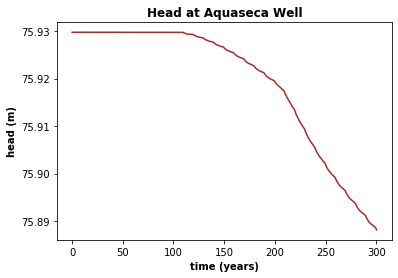

In [15]:
# Aquaseca well
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')

cell_id1 = well_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at Aquaseca Well",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-', color="brown") #plot the time series with points at each record

plt.savefig("Head_Aqua5"+str(name)+".png",dpi=600)
plt.show()


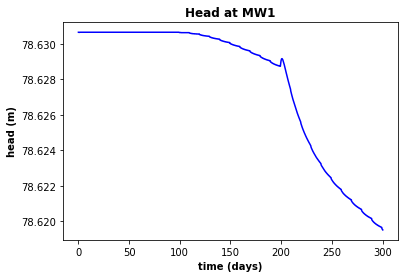

In [16]:
# Monitoring well 1

cell_id1 = well2_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at MW1",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-') #plot the time series with points at each record
# plt.plot(time_series1[900:, 0], time_series1[900:, 1], 'b-') #less data

plt.savefig("Head_M1"+str(name)+".png",dpi=600)
plt.show()

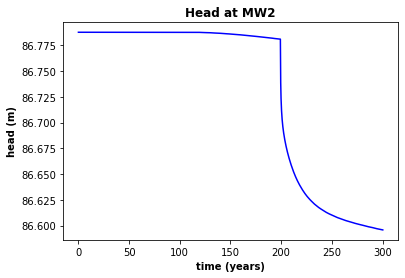

In [17]:
# Monitoring well 2
cell_id1 = well3_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at MW2",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
#plt.ylim(87, 92)
plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-') #plot the time series with points at each record

plt.savefig("Head_M2"+str(name)+".png", dpi=600)
plt.show()


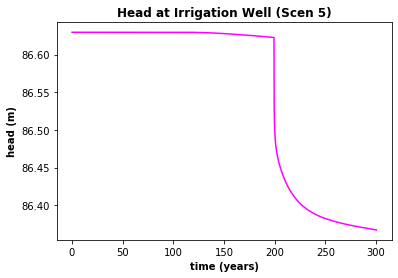

In [18]:
# Irrigation well
cell_id1 = well4_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at Irrigation Well (Scen 5)",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
#plt.ylim(89, 92)
plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-', color="magenta") #plot the time series with points at each record

plt.savefig("Head_irri"+str(name)+".png", dpi=600)
plt.show()